In [1]:
import numpy as np
import pandas as pd

from visualize.representation_projection import plot_rotation_ablation

# Klasyfikacja emocji z twarzy z użyciem modeli grafowych

## Raport z projektu na kurs Uczenie reprezentacji
### *Michał Ilski, Jan Pawłowski, Patryk Rygiel*

# 1. Wstęp

W ramach projektu zajmujemy się klasyfikacją emocji na podstawie wyrazu twarzy. Jest to problem klasyfikacji wieloklasowej, gdzie mamy do czynienia z $7$ klasami emocji: 

* anger, 
* contempt, 
* disgust, 
* fear, 
* happy, 
* sadness,
* surprise.

## 1.1 Metodologia

![](images/representation-raport/metodology.png)

Nasza metoda oparta jest ekstrakcji ze zdjęć tzw. [`FaceMesh`](https://google.github.io/mediapipe/solutions/face_mesh.html#:~:text=MediaPipe%20Face%20Mesh%20is%20a,for%20a%20dedicated%20depth%20sensor.) przy użyciu pre-trenowanego narzędnia `MediaPipe`. `FaceMesh` to reprezentacja twarzy w formie siatki 3D składającej się z $468$ punktów charakterystycznych. Tak uzyskane siatki są używane jako zbiór do trenowania i ewaluacji modeli grafowych, których używamy w tym projekcie.

Takie podejście jest dobrą generalizację, gdy mamy mało danych uczących, które są tendencyjne (np. czarno białe, twarz zawsze na środku zdjęcia). Model nie overfittuje się do tekstur na zdjęciu, jedyne na czym działa to kształt twarzy.

## 1.2 Zbiór danych

Jako zbioru danych używamy zbioru [CK+ (Extended Cohn-Kanade dataset)](https://paperswithcode.com/dataset/ck). Zbiór składa się z $593$ sekwencji video dla $123$ różnych osób. Ze wszystkich sekwencji $327$ jest oetykietowanych jedną z z $7$ emocji: anger, contempt, disgust, fear, happy, sadness, surprise. Jedna sekwencja przedstawia przejście z emocji neutralnej do zadanej emocji. Poniższa wizualizacja pokazuje sekwencje $15$ obrazów przejścia z emocji neutral do happy:

|  |  |  |  |
|--|--|--|--|
| ![](images/representation-raport/emotion-sequence/S010_006_00000001.png) | ![](images/representation-raport/emotion-sequence/S010_006_00000002.png) | ![](images/representation-raport/emotion-sequence/S010_006_00000003.png) | ![](images/representation-raport/emotion-sequence/S010_006_00000004.png) |
| ![](images/representation-raport/emotion-sequence/S010_006_00000005.png) | ![](images/representation-raport/emotion-sequence/S010_006_00000006.png) | ![](images/representation-raport/emotion-sequence/S010_006_00000007.png) | ![](images/representation-raport/emotion-sequence/S010_006_00000008.png) |
| ![](images/representation-raport/emotion-sequence/S010_006_00000009.png) | ![](images/representation-raport/emotion-sequence/S010_006_00000010.png) | ![](images/representation-raport/emotion-sequence/S010_006_00000011.png) | ![](images/representation-raport/emotion-sequence/S010_006_00000012.png) |
| ![](images/representation-raport/emotion-sequence/S010_006_00000013.png) | ![](images/representation-raport/emotion-sequence/S010_006_00000014.png) | ![](images/representation-raport/emotion-sequence/S010_006_00000015.png) | |

Jako obrazy przedstawiające emocje wybrane zostały ostatnie $20\%$ klatki z sekwencji jako, że na nich intensywność emocji jest największa i dostajemy parę różnych przykładów emocji dla osoby. Jako, że dla każdej osoby wybierana jest więcej niż jedna klatka z sekwencji oraz dla jednej osoby istnieje z reguły więcej niż jedna sekwencja (rodzaj emocji), zbiór danych został podzielony na poziomie osób, aby uniknąć przelewu danych treningowych do zbioru testowego. Zbiór został podzielony z uwzględnieniem stratyfikacji emocji (na ile to było możliwe) na zbiór treningowy ($85$ osób - $1148$ zdjęć) oraz testowy ($38$ osób - $484$ zdjęć). Poniższy wykres obrazuje rozkład klas w obu zbiorach:

![](images/representation-raport/split-dist.png)

Tak jak to zostało opisane w ppkt `Metodologia`, ze zdjęć została dokonana esktrakcja `FaceMesh`'y. Poniżej przedstawione są przykładowe siatki dla klas emocji:

| Anger | Contempt | Disgust | Fear |
|--|--|--|--|
| ![Anger](images/representation-raport/mesh-emotions/anger.png) | ![Contempt](images/representation-raport/mesh-emotions/contempt.png) | ![Disgust](images/representation-raport/mesh-emotions/disgust.png) | ![Fear](images/representation-raport/mesh-emotions/fear.png) |
| Happy | Sadness | Surprise |
| ![Happy](images/representation-raport/mesh-emotions/happy.png) | ![Sadness](images/representation-raport/mesh-emotions/sadness.png) | ![Surprise](images/representation-raport/mesh-emotions/surprise.png) |

## 1.3 Modele

Do uczenia na wygenerowanych siatkach 3D, przetestowaliśmy modele na reprezentacji danych wejściowych w postaci chmur punktów (tylko wierzchołki, brak krawędzi) oraz w postaci grafów (wierzchołki i krawędzie). Przetestowaliśmy także dwie metody przedstawienia cech wejściowych wierzchołków: 
* XYZ - koordynaty 3D wierzchołków
* HKS - (heat kernel signatures) sygnatury ciepła na siatce, przedstawiają dywergencje gradientu w lokalnym otoczeniu punktu. Sygnatury ciepła uzyskuje się poprzez przejście z bazy cech przestrzennych do bazy cech spektralnych przy użyciu dekompozycji na bazę wektorów własnych operatora Laplace'a-Beltrami'ego. Kolejne wektroy własne przedstawiają częstotliwość gradientu. W ramach zadania korzystamy z bazy $16$ wektorów własnych. Poniżej przedstawione są wartości konkretnych wektorów własnych w reprezentacji HKS.

| Wektor własny 1 | Wektor własny 5 | Wektor własny 10 | Wektor własny 15 |
|--|--|--|--|
| ![](images/representation-raport/hks/hks-1.png) | ![](images/representation-raport/hks/hks-5.png) | ![](images/representation-raport/hks/hks-10.png) | ![](images/representation-raport/hks/hks-15.png) |

Przetestowaliśmy następujące architektury modeli grafowych:
* [DGCNN](https://arxiv.org/abs/1801.07829) - model do przetwarzania chmur punktów oparty na dynamicznym grafie budowanym po odległościach wektorów reprezentacji punktów
* [GraphSage](https://arxiv.org/abs/1706.02216) - model do przetwarzania grafów bez ukierunkowania na stricte siatki 3D
* [FeaSt](https://arxiv.org/abs/1706.05206) - model do przetwarzania siatek 3D w formie grafów

## 1.4 Badane zagadnienie w kontekście uczenia reprezentacji

1. Z założenia siatki 3D powinniśmy procesować w taki sposób aby ich rotacja w przestrzeni (symetrie grupy SO(3)) nie wpływała na budowaną reprezentację:
* Jaki wpływ ma dobór architektury i danych wejściowych (chmura punktów vs mesh) na inwariancję SO(3) ? 
* Jaki wpływ ma wybór cech wejściowych dla wierzchołków (XYZ vs HKS) na inwariancję SO(3)?
* Czy nauka modeli z augmentacjami SO(3) pozwala uzyskać inwariantną reprezentację?

2. Analiza wyuczonych reprezentacji pomiędzy emocjami i osobami:
* Reprezentacje, których emocji są bliskie siebie? Dlaczego? 
* Czy dla jednej osoby jej różne emocje będą miały podobną reprezentację przy uczeniu pod zadaniem klasyfikacji emocji?

3. Analiza rozkładu map aktywacji klas na siatce twarzy:
* Czy aktywowane obszary pokrywają się z klasycznymi deskryptorami emocji? uniesione brwi, otwarte usta itp.
* Które emocje mają między sobą wspólne obszary aktywacji?

*UWAGA: w ramach skłądanych założeń zadania napisaliśmy, że przetestujemy także model [GEM-CNN](https://arxiv.org/abs/2003.05425). Niestety w naszym przypadku ten model nie zadziała, gdyż zakłada on, że mesh jest manifoldem, co nie jest prawdziwe dla naszych danych - krawędzie na obrzeżu maski mają tylko po jednej ścianie, do której należą.

## 1.5* Skrypty i kod

W folderze `run` znajduja się skrypty:
* `export_meshes` - przeprocesowanie zbioru danych na siatki 3D
* `train` - nauka wybranego modelu
* `inference` - inferencja wybranego modelu
* `run_preview` - przetestowanie wybranego modelu na kamerze komputera

W folderze `src` znajdują się implementacje modeli, zbioru danych i transformacji.

Odpalenie przykładowego treningu (model SAGE z cechami XYZ):
```
python -m run.train --model-name sage --features xyz
```

# 2. Analiza zagadnień

## 2.1 Inwariantność na rotacje 3D (symetrie grupy SO(3))

Przy procesowaniu siatek 3D zależy nam inwariancji w obrębie symetrii grupy SO(3) - grupa rotacji w 3D. O ile translacje nie są problem w settingu testowym, gdyż zawsze możemy łatwo wyśrodkować siatkę w punkcie $0.0$ i zeskalować do zadanej przestrzeni, o tyle rotacje są wyzwaniem. 

W ramach tego eksperymentu sprawdzamy jak różne modele i różne reprezentacje cech radzą sobie z inwariancją na rotacje w zadaniu klasyfikacji emocji. 

### 2.1.1 Trening bez rotacji

W pierwszym teście trenujemy modele bez augmentacji danych w postaci rotacji. Dokonujemy ewaluacji na domyślnym zbiorze testowym (F1-macro) oraz na zbiorze testowym z nałożonymi losowymi rotacjami (F1-macro z rotacjami).

| Model | Cechy | F1-macro (%) | F1-macro z rotacjami (%) |
|--|--|--|--|
| DGCNN | XYZ | 82.94 |  7.20 |
| DGCNN | HKS | 71.64 | 72.86 |
| | | |
| SAGE  | XYZ | 75.97 |  6.31 |
| SAGE  | HKS | 77.86 | 71.96 |
| | | |
| FEAST | XYZ | 76.36 | 13.60 |
| FEAST | HKS | 73.54 | 69.23 |

Analizując wyniki, zauważamy, że najlepsze wyniki na domyślnym zbiorze testowym osiąga model DGCNN z cechami XYZ. Jednak, gdy testujemy go na zbiorze z rotacjami, jak i każdy inny model na cechach XYZ, zauważamy ogromny spadek w jakości klasyfikacji - praktycznie wyniki są losowe. Dla cech HKS natomiast widzimy, że inwariantność na rotacje jest zachowana. Nie jest to niespodzianka, gdyż sygnatury ciepła są zależne tylko od kształtu siatki niezależnie od tego w jakim miejscu przestrzeni owa siatka się znajduje.

### 2.1.2 Trening z rotacjami

W drugim teście trenujemy modele z augmentacją danych w postaci losowych rotacji. Ewaluacji dokonujemy w ten sam sposób co w teście pierwszym.

| Model | Cechy | F1-macro (%) | F1-macro z rotacjami (%) |
|--|--|--|--|
| DGCNN | XYZ | 51.40 | 43.26 |
| DGCNN | HKS | 70.96 | 74.68 |
| | | |
| SAGE  | XYZ | 11.51 |  8.30 |
| SAGE  | HKS | 70.35 | 72.42 |
| | | |
| FEAST | XYZ | 12.16 |  9.19 |
| FEAST | HKS | 76.81 | 70.29 |

Tym razem dostrzegamy, że DGCNN z XYZ osiąga lepsze wyniki na zbiorze z rotacjami, jednak są one dużo słabsze niż to co są w stanie osiągnąć modele z cechami HKS. Modele SAGE i FEAST nie są w stanie się zbytnio niczego nauczyć przy użyciu cech XYZ, gdy dokonujemy rotacji. Ponownie bez zaskoczeń, przy wykorzystaniu cech HKS wyniki są takie same jak przy trenowaniu modelu bez rotacji.

### Wnioski

Inwariantność na dane symetrie (w naszym przypadku SO(3)) możemy wymusić na dwa sposoby:
* Augmentacja danych w obrębie symetrii grupy
* Budowa reprezentacji inwariantnej na symetrie (inwariantny model lub reprezentacja danych wejściowych)

Na podstawie przeprowadzonych eksperymentów, ewidentnie zauważamy, że budowa inwariantnej reprezentacji jest lepszy podejściem. Prawdopodobnie, zastosowanie augmentacji zbioru mogłoby dać zbliżone wyniki, jednak wymgałoby ono zdecydowanego powiększenia zbioru danych, aby móc dobrze pokryć powiększoną przesztrzeń danych wejściowych. Używając modeli / reprezentacji inwariantnych na symetrie nie potrzebujemy aż tak wielu danych, gdyż przestrzeń danych wejściowych jest zdecydowanie mniejsza.

## 2.2 Analiza wyuczonych reprezentacji klas emocji

### 2.2.1 DGCNN

#### a) Cechy XYZ uczone bez rotacji

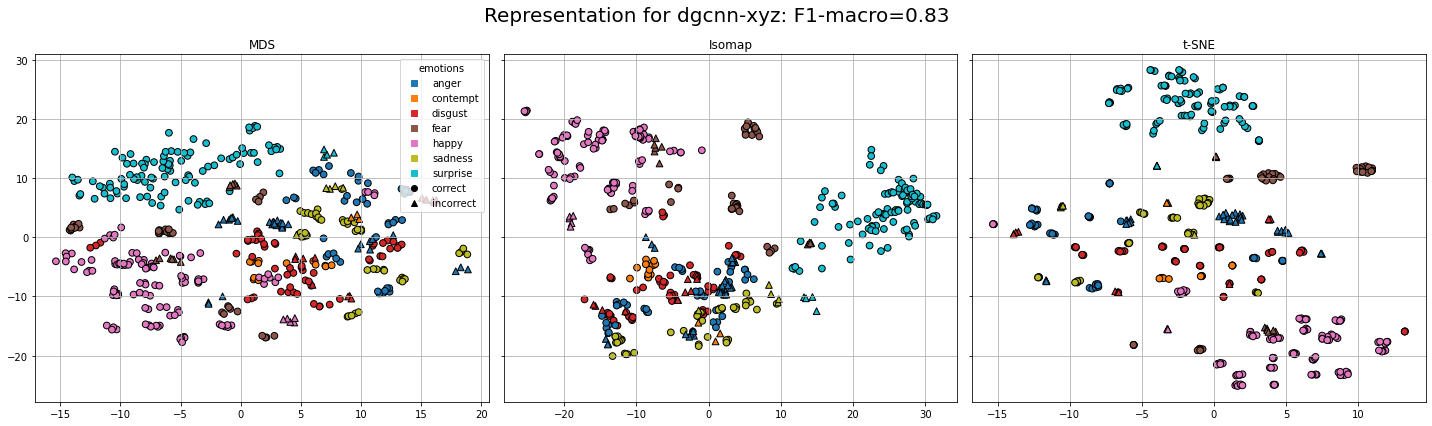

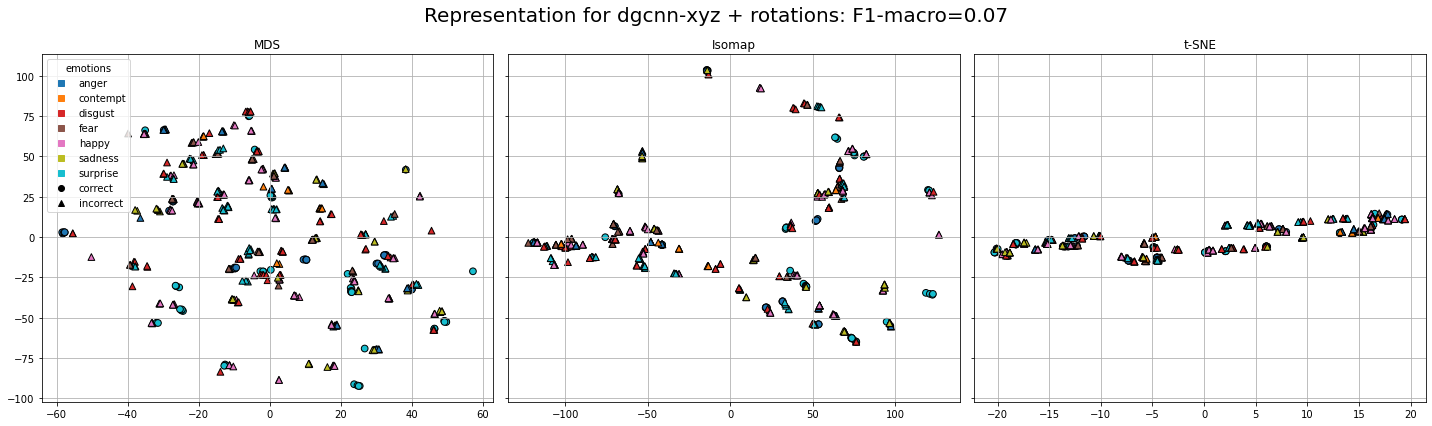

In [2]:
plot_rotation_ablation("dgcnn-xyz")

#### b) Cechy XYZ uczone z rotacjami

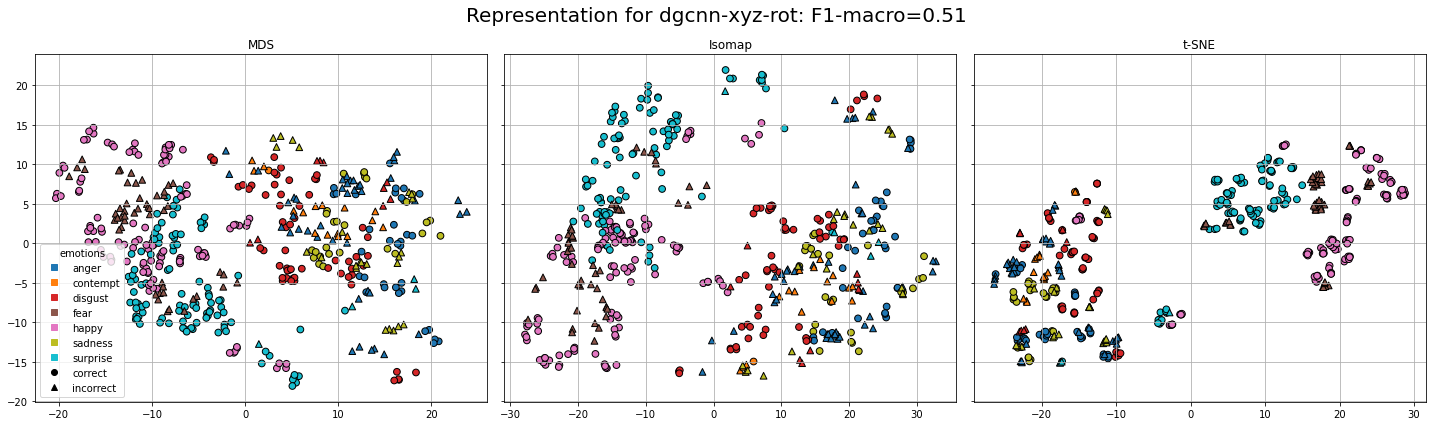

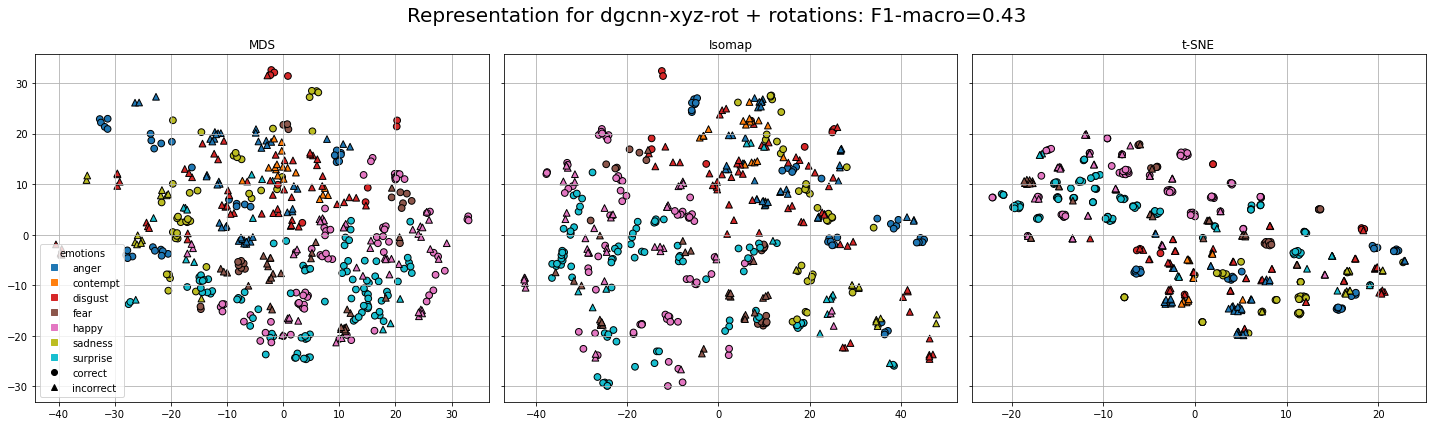

In [3]:
plot_rotation_ablation("dgcnn-xyz-rot")

#### c) Cechy HKS

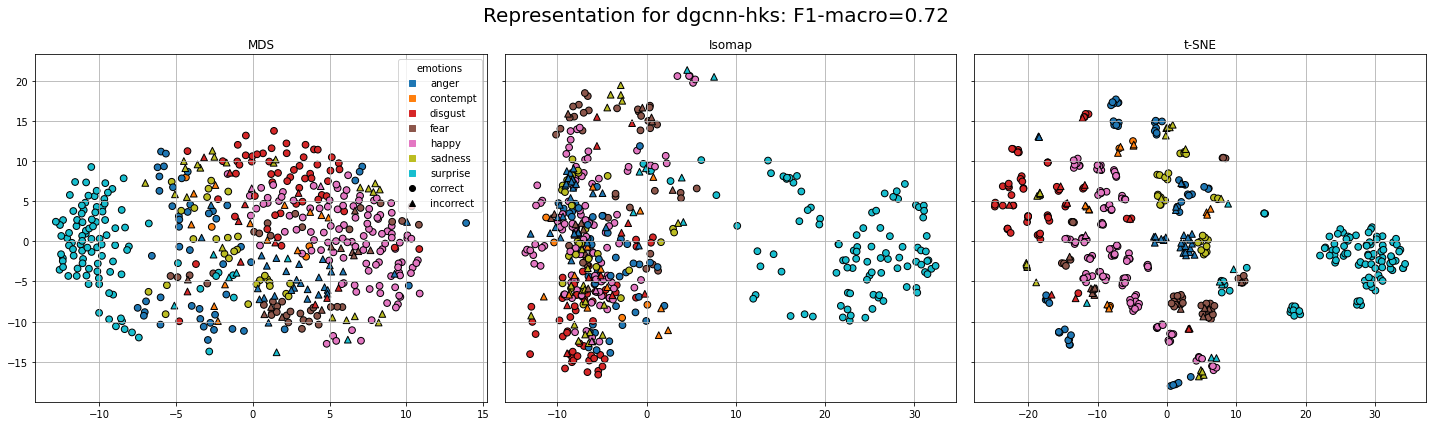

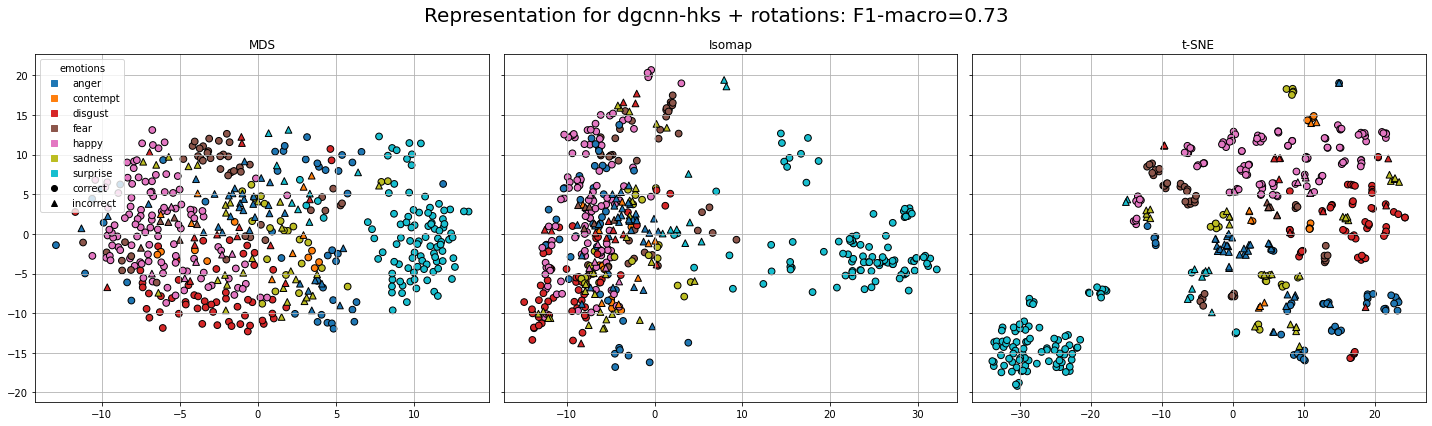

In [4]:
plot_rotation_ablation("dgcnn-hks")

## 2.3 Analiza map aktywacji klas

ToDo:
* zagregować aktywacje w obręnie klas i zwizualizować wyniki
* porównać aktywacj xyz i hks
* doliczyć mapy aktywacji dla modeli uczonych z rotacją